In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
from sklearn.preprocessing import PolynomialFeatures
import math

6993


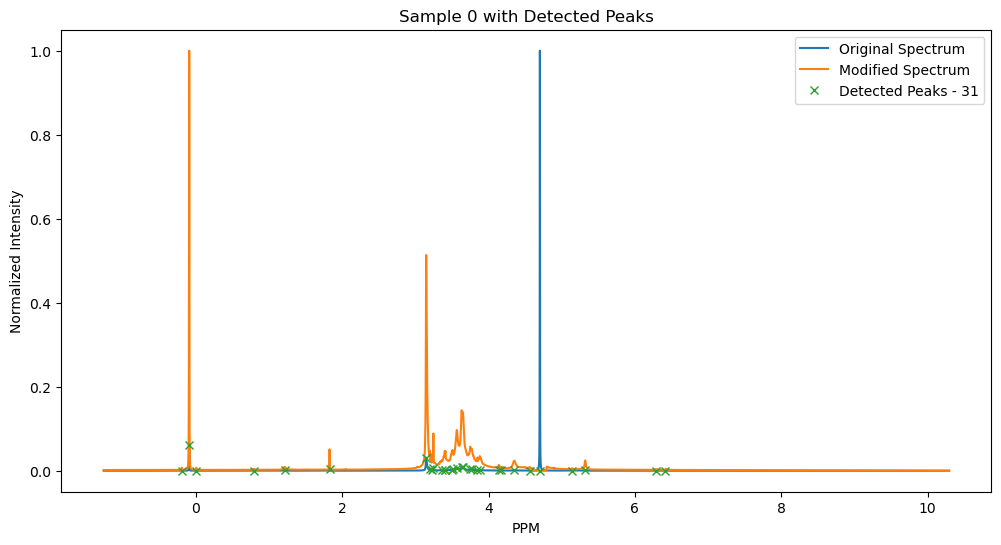

7010


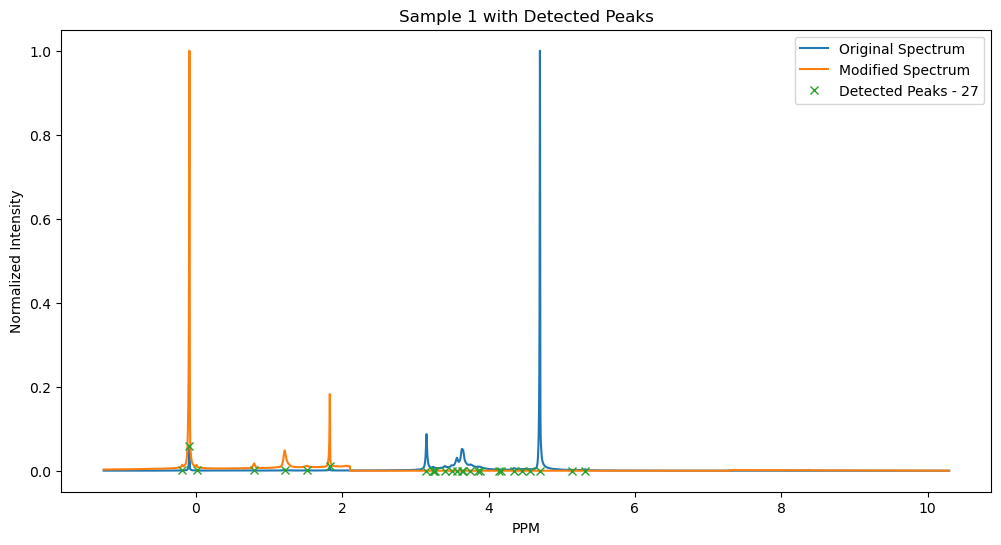

6994


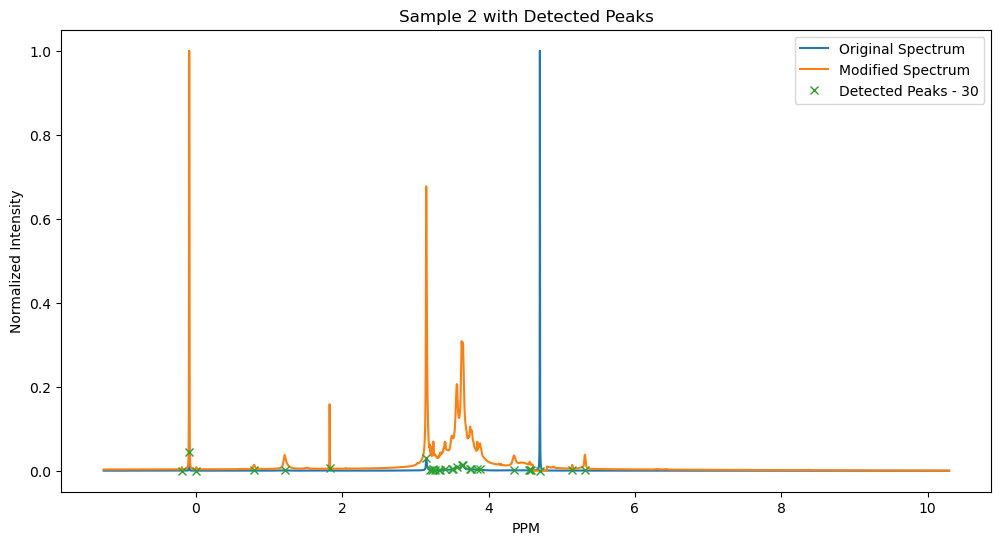

6995


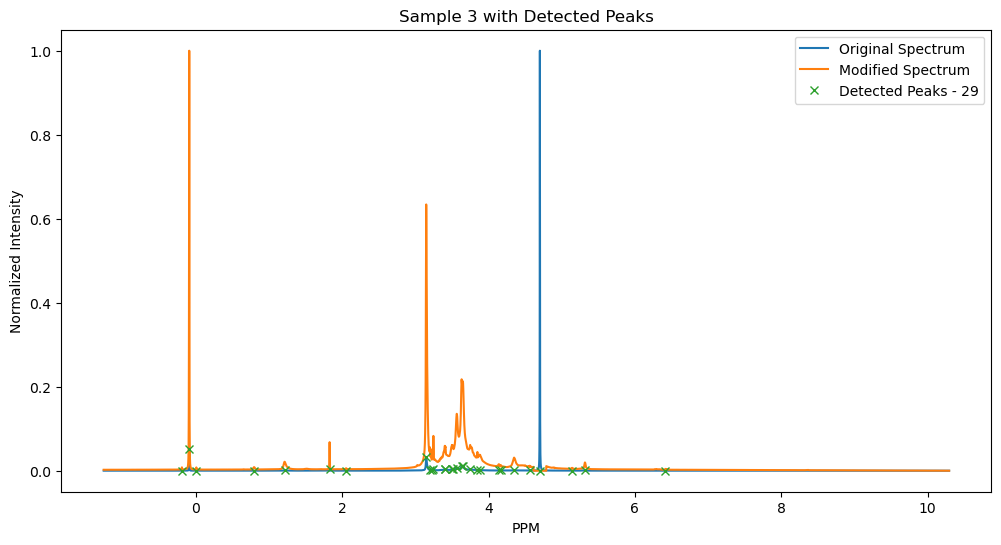

6991


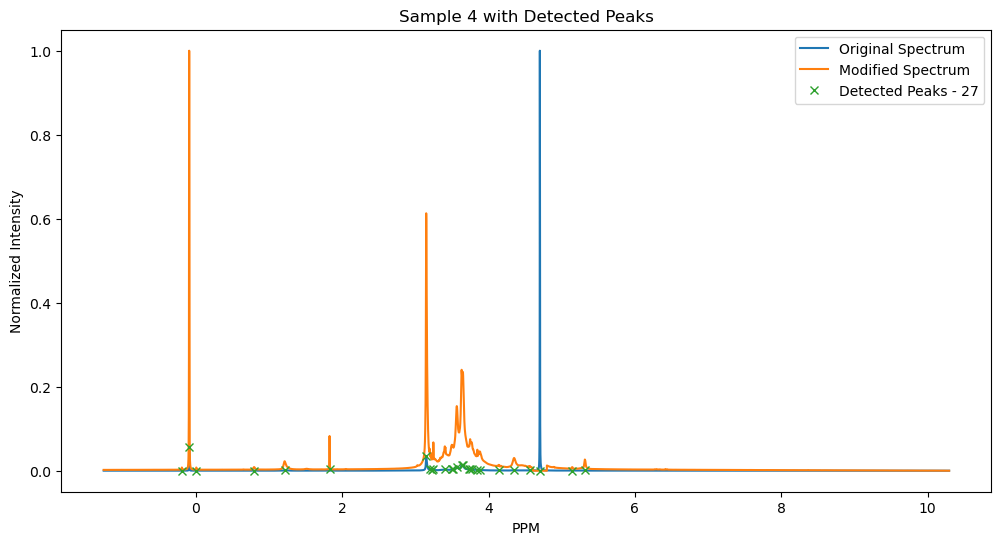

6996


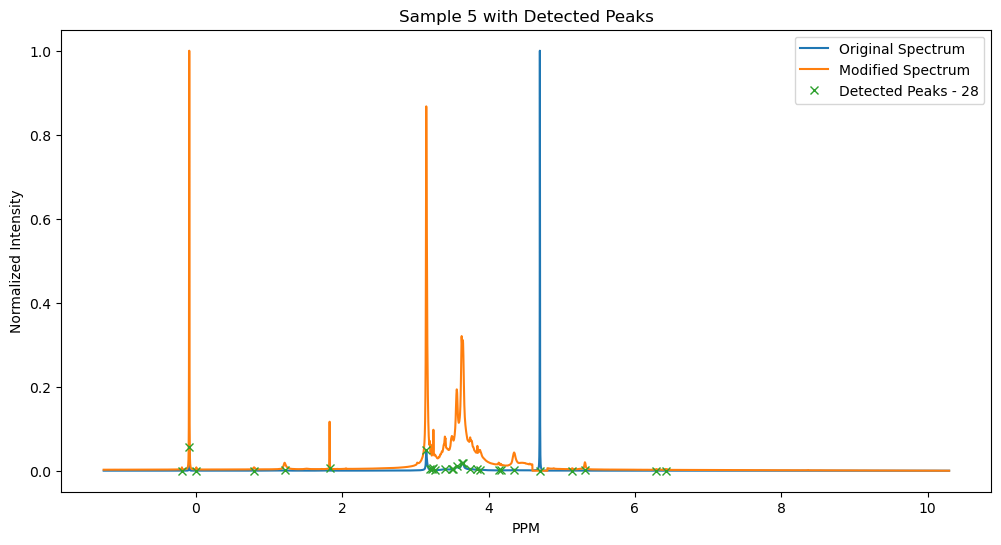

6999


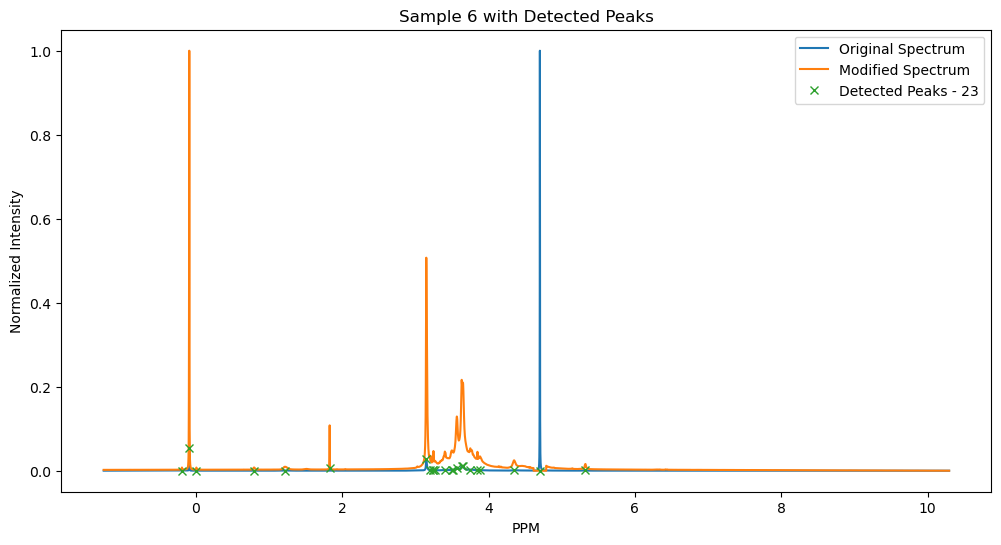

6989


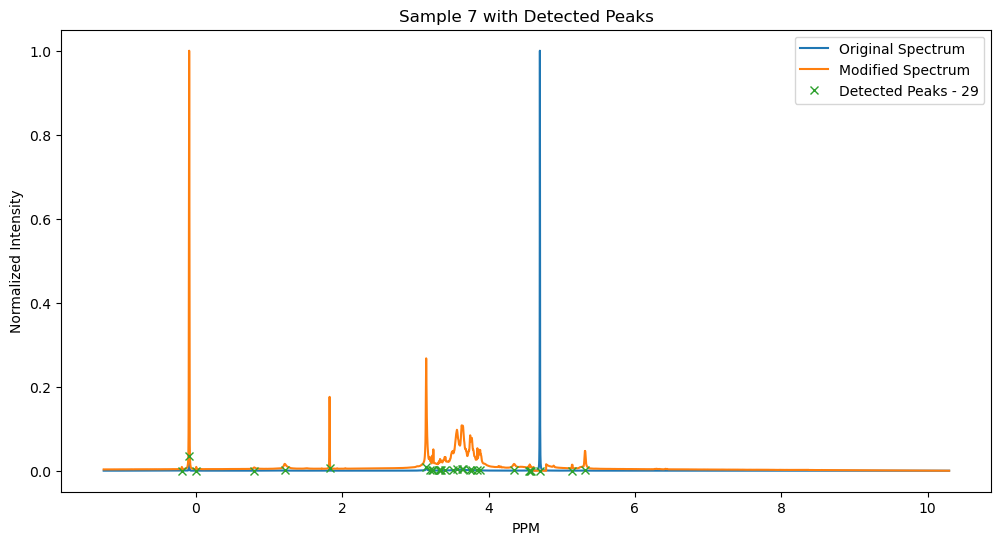

6992


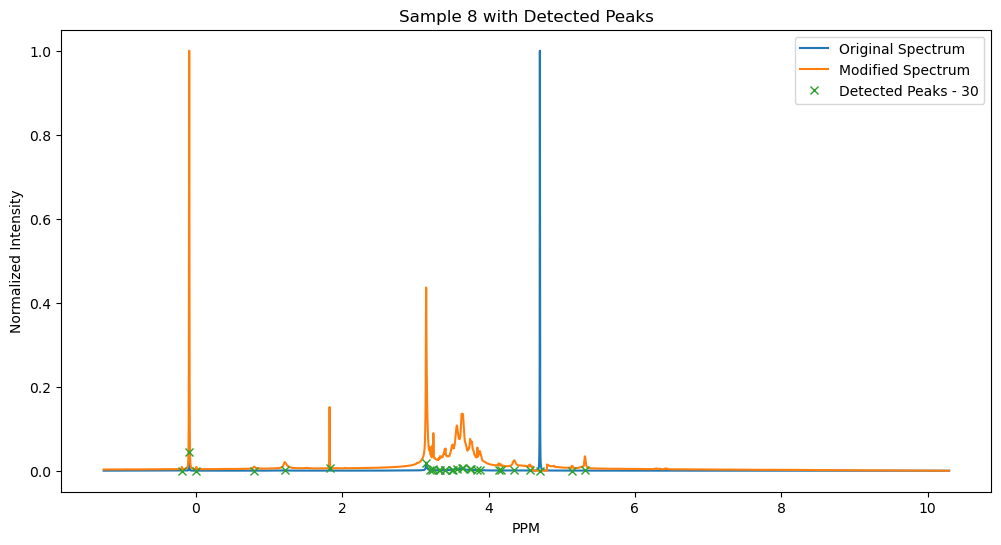

6998


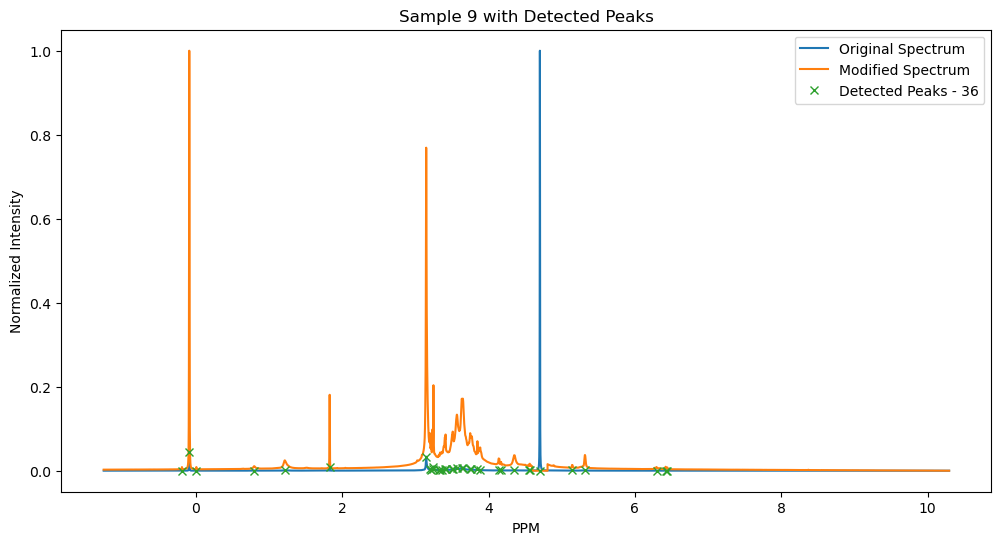

6995


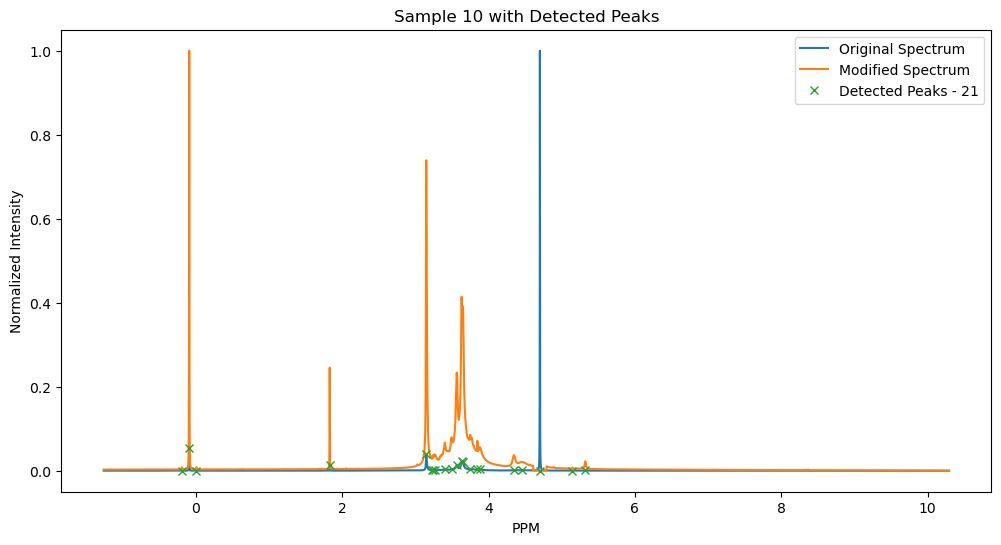

7006


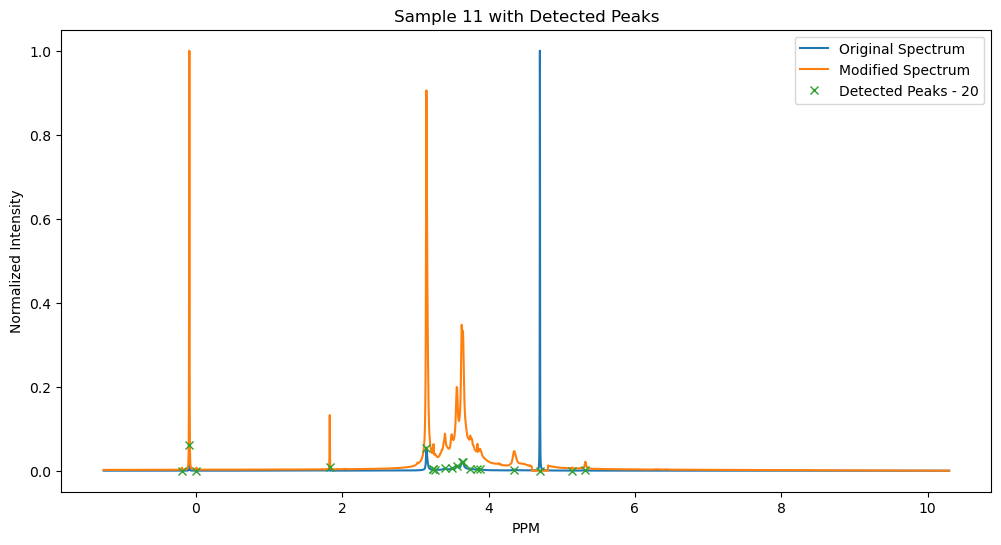

In [2]:
def load_and_normalize_data(filepath):
    nmr_df = pd.read_csv(filepath)
    index_labels = nmr_df.index
    nmr_intensity = nmr_df.filter(regex='Intensity_')
    nmr_ppm = nmr_df.filter(regex='PPM_')
    # Subtract min and divide by max-min for each row to normalize
    nmr_intensity_normalized = (nmr_intensity.subtract(nmr_intensity.min(axis=1), axis=0)
                                .div(nmr_intensity.max(axis=1) - nmr_intensity.min(axis=1), axis=0))
    return nmr_ppm, nmr_intensity_normalized, index_labels



filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/NMR_Data.csv"
nmr_ppm, normalized_intensity, index_labels = load_and_normalize_data(filepath)

whole_spectra = []
# Now we can iterate over all samples
for sample_index in range(normalized_intensity.shape[0]):
    spectrum = normalized_intensity.iloc[sample_index, :].copy()
    org_spectrum = spectrum.copy()
    peaks, _ = find_peaks(spectrum, prominence=0.0001)
    peak_index = peaks[0]
    print(peak_index)
    peak_count = len(peaks)
    widths = peak_widths(spectrum, peaks, rel_height=0.999)

    # Identify the water peak to minimize
    just_widths = widths[0]
    if len(peaks) > 0:  # Check if there are any peaks
        max_peak_index = peaks[np.argmax(spectrum.iloc[peaks])]
        max_peak_width = just_widths[np.argmax(spectrum.iloc[peaks])]
        # Set range around the water peak to minimum
        left_range = math.ceil(max_peak_index - max_peak_width)
        right_range = math.floor(max_peak_index + max_peak_width)
        spectrum[left_range:right_range] = min(spectrum)
    
    # Normalize the modified spectrum
    max_no_waterpeak_spectrum = (spectrum - min(spectrum)) / (max(spectrum) - min(spectrum))
    whole_spectra.append(max_no_waterpeak_spectrum)
    whole_spectra_df = pd.DataFrame(whole_spectra)

    plt.figure(figsize=(12, 6))
    plt.plot(nmr_ppm.iloc[sample_index, :], org_spectrum, label='Original Spectrum')
    plt.plot(nmr_ppm.iloc[sample_index, :], max_no_waterpeak_spectrum, label='Modified Spectrum')
    plt.plot(nmr_ppm.iloc[sample_index, peaks], spectrum.iloc[peaks], "x", label=f'Detected Peaks - {peak_count}')
    plt.title(f'Sample {sample_index} with Detected Peaks')
    plt.xlabel('PPM')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.show()

#print(whole_spectra_df)

In [3]:
def perform_anova(nmr_ppm, nmr_intensity, bin_size):

    total_points = nmr_intensity.shape[1]
    num_bins = total_points // bin_size
    remaining_points = total_points % bin_size
    anova_results = pd.DataFrame()
    anova_data = []

    for bin_index in range(num_bins + int(remaining_points > 0)):
        start = bin_index * bin_size
        if bin_index < num_bins:
            end = start + bin_size
        else:
            end = start + remaining_points
        
        current_bin_intensity = nmr_intensity.iloc[:, start:end].values.flatten()
        current_bin_size = end - start
        current_bin_ppm = np.tile(nmr_ppm.iloc[:, start:end].values.flatten(), nmr_intensity.shape[0])[:len(current_bin_intensity)]
        current_bin_materials = np.repeat(nmr_intensity.index, current_bin_size)[:len(current_bin_intensity)]

        anova_data = pd.DataFrame({
            'Intensity': current_bin_intensity,
            'PPM': current_bin_ppm,
            'Material': current_bin_materials
        })

        print(anova_data)



        anova = AnovaRM(data=anova_data, depvar='Intensity', subject='Material', within=['PPM']).fit()

        anova_results = anova_results.append({
            'Bin': bin_index + 1,
            'F-Value': anova.anova_table['F Value'][0],
            'P-Value': anova.anova_table['Pr > F'][0],
            'DF Within': anova.anova_table['Num DF'][0],
            'DF Between': anova.anova_table['Den DF'][0]
        }, ignore_index=True)
    
        anova_data.append(anova_data)

    return anova_results, anova_data



bin_size = 300

anova_results, anova_data = perform_anova(nmr_ppm, whole_spectra_df, bin_size)


print(anova_data)
print(anova_results)


      Intensity      PPM  Material
0      0.001607 -1.25905         0
1      0.001609 -1.25890         0
2      0.001612 -1.25874         0
3      0.001616 -1.25859         0
4      0.001621 -1.25844         0
...         ...      ...       ...
3595   0.002004 -1.21398        11
3596   0.002006 -1.21382        11
3597   0.002009 -1.21367        11
3598   0.002011 -1.21352        11
3599   0.002014 -1.21337        11

[3600 rows x 3 columns]
      Intensity      PPM  Material
0      0.001655 -1.21321         0
1      0.001660 -1.21306         0
2      0.001664 -1.21291         0
3      0.001672 -1.21275         0
4      0.001677 -1.21260         0
...         ...      ...       ...
3595   0.002022 -1.16814        11
3596   0.002022 -1.16799        11
3597   0.002023 -1.16783        11
3598   0.002022 -1.16768        11
3599   0.002022 -1.16753        11

[3600 rows x 3 columns]
      Intensity      PPM  Material
0      0.001650 -1.16737         0
1      0.001650 -1.16722         0
2    

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/statsmodels/stats/anova.py:606: RuntimeWarning: invalid value encountered in scalar divide
  F = msm / mse


      Intensity      PPM  Material
0           0.0  4.69992         0
1           0.0  4.70008         0
2           0.0  4.70023         0
3           0.0  4.70038         0
4           0.0  4.70054         0
...         ...      ...       ...
3595        0.0  4.74500        11
3596        0.0  4.74515        11
3597        0.0  4.74530        11
3598        0.0  4.74546        11
3599        0.0  4.74561        11

[3600 rows x 3 columns]


/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/statsmodels/stats/anova.py:606: RuntimeWarning: invalid value encountered in scalar divide
  F = msm / mse


      Intensity      PPM  Material
0           0.0  4.74576         0
1           0.0  4.74592         0
2           0.0  4.74607         0
3           0.0  4.74622         0
4           0.0  4.74637         0
...         ...      ...       ...
3595        0.0  4.79084        11
3596        0.0  4.79099        11
3597        0.0  4.79114        11
3598        0.0  4.79130        11
3599        0.0  4.79145        11

[3600 rows x 3 columns]
      Intensity      PPM  Material
0      0.000000  4.79160         0
1      0.000000  4.79175         0
2      0.000000  4.79191         0
3      0.000000  4.79206         0
4      0.000000  4.79221         0
...         ...      ...       ...
3595   0.010876  4.83667        11
3596   0.010864  4.83683        11
3597   0.010852  4.83698        11
3598   0.010845  4.83713        11
3599   0.010840  4.83729        11

[3600 rows x 3 columns]
      Intensity      PPM  Material
0      0.007169  4.83744         0
1      0.007160  4.83759         0
2    

In [4]:
def extract_data_from_significant_bins(data, significant_bins, bin_size):
    # Initialize a list to hold the DataFrame for each sample
    extracted_data = []

    # Iterate over each sample in the dataset
    for sample_index in range(data.shape[0]):
        sample_data = []

        # Iterate over each significant bin to extract data
        for _, bin_row in significant_bins.iterrows():
            start_index = int((bin_row['Bin'] - 1) * bin_size)
            end_index = min(start_index + bin_size, data.shape[1])

            # Extract the intensities for the current bin and sample
            current_bin_data = data.iloc[sample_index, start_index:end_index]

            
            sample_data.extend(current_bin_data.values)

        # Append the sample data to the list
        extracted_data.append(sample_data)

    # Convert the list of lists to a DataFrame
    num_columns = len(extracted_data[0])  # Number of columns for the DataFrame
    return pd.DataFrame(extracted_data, columns=[f'Intensity_{i}' for i in range(num_columns)])


#bin_size = 300
significant_bins = anova_results[anova_results['P-Value'] < 0.05]

print(significant_bins)

extracted_data = extract_data_from_significant_bins(whole_spectra_df, significant_bins, bin_size)
print(extracted_data)


       Bin  DF Between  DF Within   F-Value       P-Value
0      1.0      3289.0      299.0  2.931590  7.153866e-49
1      2.0      3289.0      299.0  2.276228  1.332751e-27
2      3.0      3289.0      299.0  1.475192  6.896891e-07
3      4.0      3289.0      299.0  1.800023  3.370932e-14
6      7.0      3289.0      299.0  1.537142  4.001720e-08
..     ...         ...        ...       ...           ...
248  249.0      3289.0      299.0  1.562615  1.174313e-08
249  250.0      3289.0      299.0  3.453091  5.823600e-67
250  251.0      3289.0      299.0  2.465151  1.736291e-33
251  252.0      3289.0      299.0  1.920907  2.338394e-17
252  253.0       132.0       12.0  3.950720  3.345879e-05

[228 rows x 5 columns]
    Intensity_0  Intensity_1  Intensity_2  Intensity_3  Intensity_4  \
0      0.001607     0.001609     0.001612     0.001616     0.001621   
1      0.002945     0.002944     0.002949     0.002958     0.002965   
2      0.002907     0.002911     0.002914     0.002917     0.002921

In [5]:

def extract_and_bin_data(data, ppm_values, significant_bins, bin_size):
    binned_areas = []

    # Iterate over each sample in the dataset
    for sample_index in range(data.shape[0]):
        sample_areas = []

        # Iterate over each significant bin to extract data and compute the area under the curve
        for _, bin_row in significant_bins.iterrows():
            start_index = int((bin_row['Bin'] - 1) * bin_size)
            end_index = min(start_index + bin_size, data.shape[1])

            # Extract the intensities and corresponding PPM values for the current bin and sample
            current_bin_data = data.iloc[sample_index, start_index:end_index]
            current_bin_ppm = ppm_values.iloc[:, start_index:end_index]

            # Calculate the area under the curve using np.trapz
            area = np.trapz(current_bin_data, current_bin_ppm.iloc[0])
            sample_areas.append(area)

        # Append the binned areas for the current sample
        binned_areas.append(sample_areas)

    # Convert the list of lists to a DataFrame
    num_columns = len(binned_areas[0])  # Number of columns for the DataFrame
    return pd.DataFrame(binned_areas, columns=[f'Area_Bin_{i+1}' for i in range(num_columns)])

binned_data = extract_and_bin_data(whole_spectra_df, nmr_ppm, significant_bins, bin_size)

print(binned_data)

    Area_Bin_1  Area_Bin_2  Area_Bin_3  Area_Bin_4  Area_Bin_5  Area_Bin_6  \
0     0.000075    0.000077    0.000077    0.000078    0.000080    0.000080   
1     0.000136    0.000139    0.000142    0.000146    0.000158    0.000161   
2     0.000133    0.000133    0.000135    0.000136    0.000138    0.000139   
3     0.000104    0.000105    0.000106    0.000107    0.000109    0.000110   
4     0.000091    0.000092    0.000092    0.000093    0.000095    0.000095   
5     0.000110    0.000110    0.000111    0.000113    0.000114    0.000115   
6     0.000094    0.000094    0.000095    0.000095    0.000097    0.000098   
7     0.000142    0.000144    0.000145    0.000146    0.000149    0.000151   
8     0.000133    0.000135    0.000136    0.000138    0.000141    0.000143   
9     0.000115    0.000117    0.000117    0.000119    0.000124    0.000125   
10    0.000122    0.000122    0.000123    0.000124    0.000125    0.000126   
11    0.000091    0.000092    0.000093    0.000092    0.000095  

         PC1       PC2       PC3
0   0.003524 -0.001486 -0.000116
1   0.018009 -0.000491 -0.002320
2  -0.005431  0.002367  0.000983
3  -0.000716 -0.000935 -0.000409
4  -0.001310  0.000361 -0.000078
5  -0.007675 -0.000798 -0.000710
6   0.002052  0.000993 -0.000649
7   0.007573  0.001419  0.001822
8   0.003659 -0.000227  0.002010
9  -0.001960 -0.002523  0.002330
10 -0.006708  0.004237 -0.001190
11 -0.011018 -0.002916 -0.001673
[0.8788447  0.05953811 0.03196708]


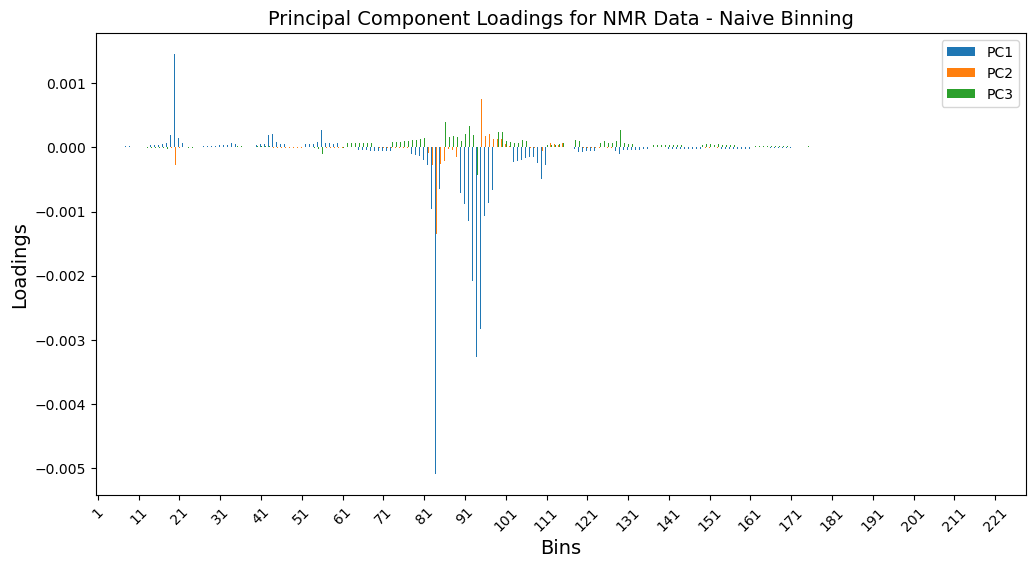

In [6]:
binned_data.columns = [col.replace('Bin', 'Peak') for col in binned_data.columns]

binned_data.columns = [str(i+1) for i in range(len(binned_data.columns))]

pca = PCA(n_components=3)
principal_components = pca.fit_transform(binned_data)

principal_components_df = pd.DataFrame(principal_components,index=index_labels, columns=['PC1', 'PC2', 'PC3'])
print(principal_components_df)
print(pca.explained_variance_ratio_)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=binned_data.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)


ax.set_title('Principal Component Loadings for NMR Data - Naive Binning', fontsize=14)
ax.set_ylabel('Loadings', fontsize=14)
ax.set_xlabel('Bins', fontsize=14)

# Reduce the number of x-ticks
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])  # Show every 10th label
ax.xaxis.set_ticklabels(ticklabels[::10], rotation=45)  # Rotate labels for better fit

plt.show()

In [7]:
principal_components_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/PC_naive_NMR.csv")

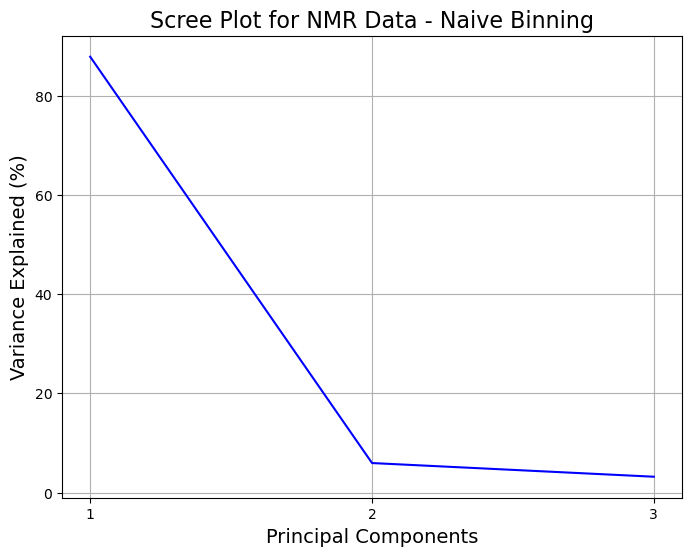

In [8]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for NMR Data - Naive Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1)) 
plt.grid(True)
plt.show()

In [9]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']
X  = principal_components

Y.reset_index(drop=True, inplace=True)


poly = PolynomialFeatures(degree=1)
X_LP = poly.fit_transform(X)

C = sm.add_constant(X_LP)
ols_model = sm.OLS(Y, C).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.8510
Date:                Tue, 14 May 2024   Prob (F-statistic):              0.504
Time:                        11:01:25   Log-Likelihood:                -28.970
No. Observations:                  12   AIC:                             65.94
Df Residuals:                       8   BIC:                             67.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1333      0.956     16.868      0.0

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


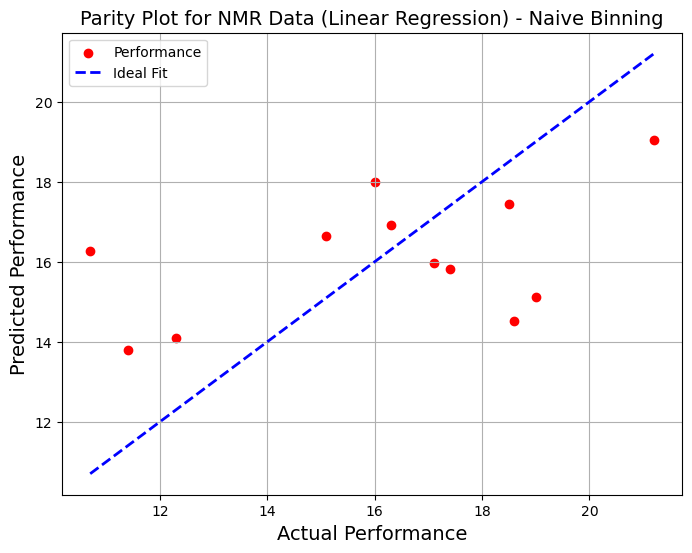

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_LP, Y)

Y_pred = lin_reg.predict(X_LP)

plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred, color= 'Red', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'b--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for NMR Data (Linear Regression) - Naive Binning', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
Y_pred

array([16.92967081, 19.04153941, 15.12620795, 15.96638885, 15.82132881,
       14.50891844, 16.2564998 , 17.99343324, 17.43811004, 16.64828542,
       14.0851744 , 13.78444281])